In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from sklearn import preprocessing
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.kernel_approximation import RBFSampler

import warnings
warnings.filterwarnings("ignore")

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

%config InlineBackend.figure_format = "retina"

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

cuda


In [2]:
def save_reconstructed_image(outputs, save_path):
    outputs = outputs.cpu().numpy().clip(0, 1)
    outputs = (outputs * 255).astype(np.uint8)
    pil_image = Image.fromarray(outputs)
    pil_image.save(save_path)

In [3]:
img = torchvision.io.read_image('dog.jpg')
print(img.shape)

torch.Size([3, 1365, 2048])


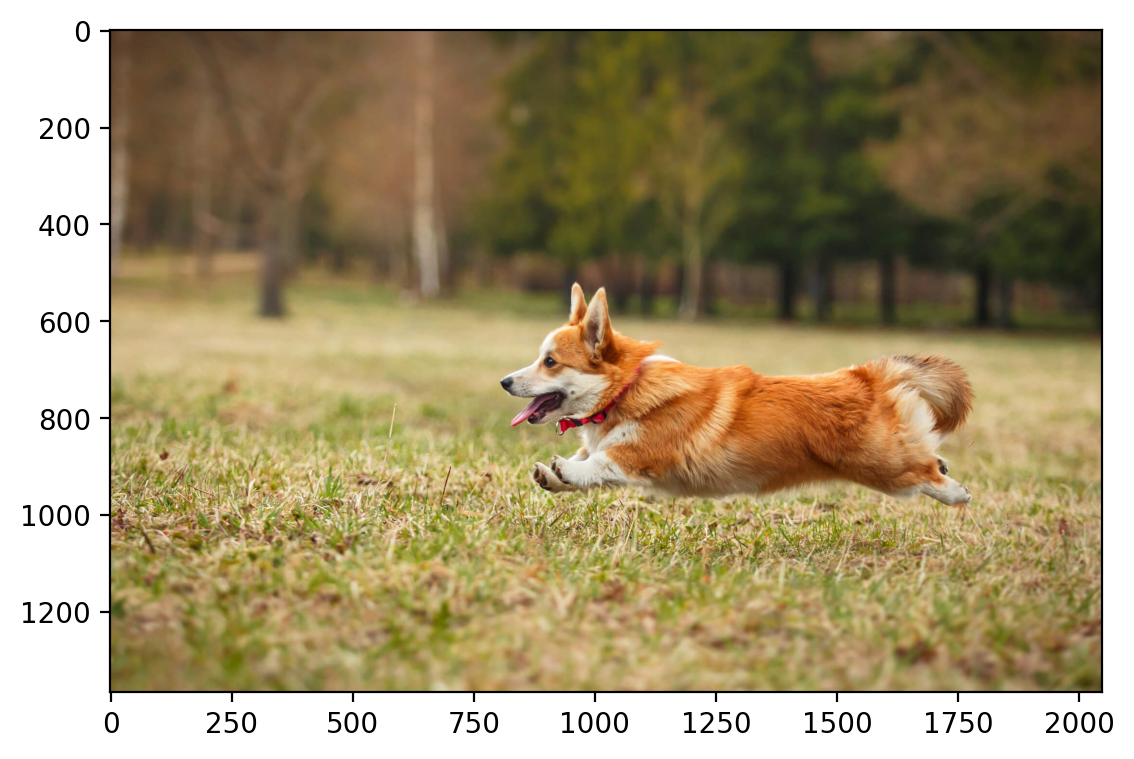

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
img_scaled = preprocessing.MinMaxScaler().fit_transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
print(img_scaled.shape)
print(img_scaled)

torch.Size([3, 1365, 2048])
tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.14

In [6]:
crop = transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop = crop.to(device)
save_reconstructed_image(rearrange(crop, 'c h w -> h w c'), "./SIRENDog/Original.png")
print(crop.shape)

torch.Size([3, 300, 300])


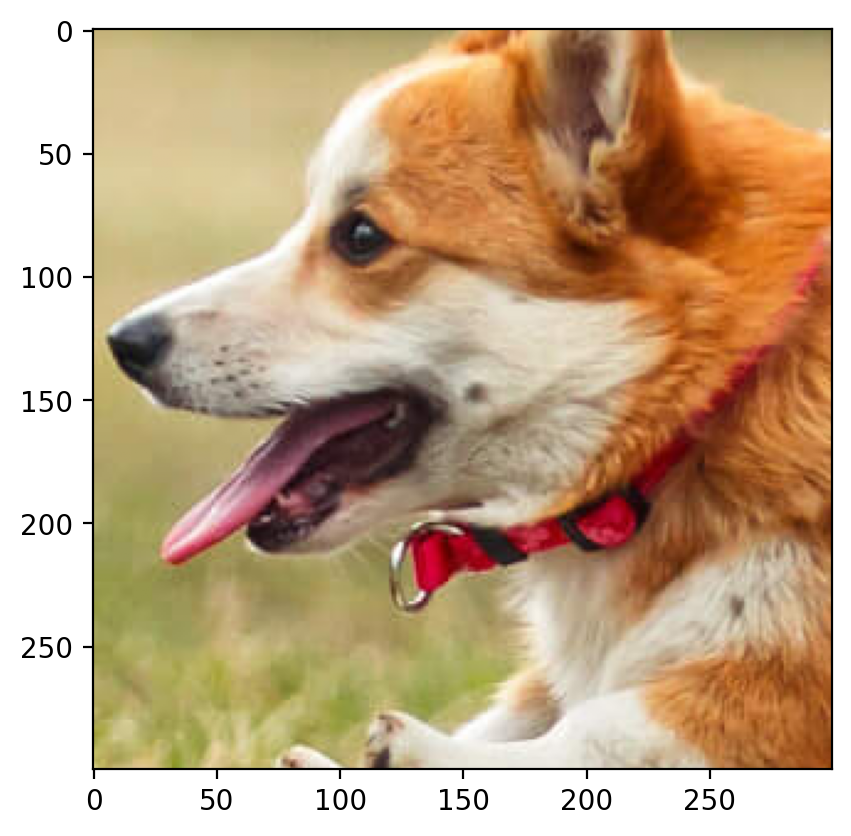

In [7]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [8]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)
    
    X = torch.stack([h_coords, w_coords], dim=1).float()

    X = X.to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [9]:
dog_X, dog_Y = create_coordinate_map(crop)
dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [10]:
print(dog_X[:10, :], '\n', dog_Y[:10, :])

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 6.],
        [0., 7.],
        [0., 8.],
        [0., 9.]], device='cuda:0') 
 tensor([[0.7686, 0.6941, 0.4745],
        [0.7686, 0.6941, 0.4745],
        [0.7686, 0.6941, 0.4745],
        [0.7686, 0.6941, 0.4745],
        [0.7686, 0.6941, 0.4745],
        [0.7686, 0.6941, 0.4745],
        [0.7686, 0.6941, 0.4745],
        [0.7686, 0.6941, 0.4745],
        [0.7608, 0.7020, 0.4784],
        [0.7608, 0.7020, 0.4784]], device='cuda:0')


In [11]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()

In [12]:
dog_X_scaled.shape, dog_X_scaled[:10, :]

(torch.Size([90000, 2]),
 tensor([[-1.0000, -1.0000],
         [-1.0000, -0.9933],
         [-1.0000, -0.9866],
         [-1.0000, -0.9799],
         [-1.0000, -0.9732],
         [-1.0000, -0.9666],
         [-1.0000, -0.9599],
         [-1.0000, -0.9532],
         [-1.0000, -0.9465],
         [-1.0000, -0.9398]], device='cuda:0'))

### Simple Single-Layered Fully Connected Linear Neural Network 

In [13]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [14]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [15]:
def plot_reconstructed_and_original_image(original_img, net, X, title = "", scale = 1, allowSave = False, fileName = None):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    height *= scale
    width *= scale
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        
    fig = plt.figure(figsize = (8, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios = [1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    if allowSave and fileName:
        save_reconstructed_image(outputs, fileName)
        
    fig.suptitle(title, y = 0.9)
    plt.tight_layout()

### Adding Random Fourier Features to Single-Layered Fully Connected Neural Network

In [16]:
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state = 42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [17]:
X_rff = create_rff_features(dog_X_scaled, 15500, 0.008)

In [18]:
X_rff.shape

torch.Size([90000, 15500])

In [19]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net, 0.01, X_rff, dog_Y, 2000)

Epoch 0 loss: 0.366625
Epoch 100 loss: 0.016008
Epoch 200 loss: 0.008775
Epoch 300 loss: 0.005597
Epoch 400 loss: 0.003786
Epoch 500 loss: 0.002678
Epoch 600 loss: 0.001970
Epoch 700 loss: 0.001503
Epoch 800 loss: 0.001190
Epoch 900 loss: 0.000976
Epoch 1000 loss: 0.000829
Epoch 1100 loss: 0.000728
Epoch 1200 loss: 0.000658
Epoch 1300 loss: 0.000609
Epoch 1400 loss: 0.000575
Epoch 1500 loss: 0.000550
Epoch 1600 loss: 0.000533
Epoch 1700 loss: 0.000520
Epoch 1800 loss: 0.000511
Epoch 1900 loss: 0.000504


0.0004985974519513547

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


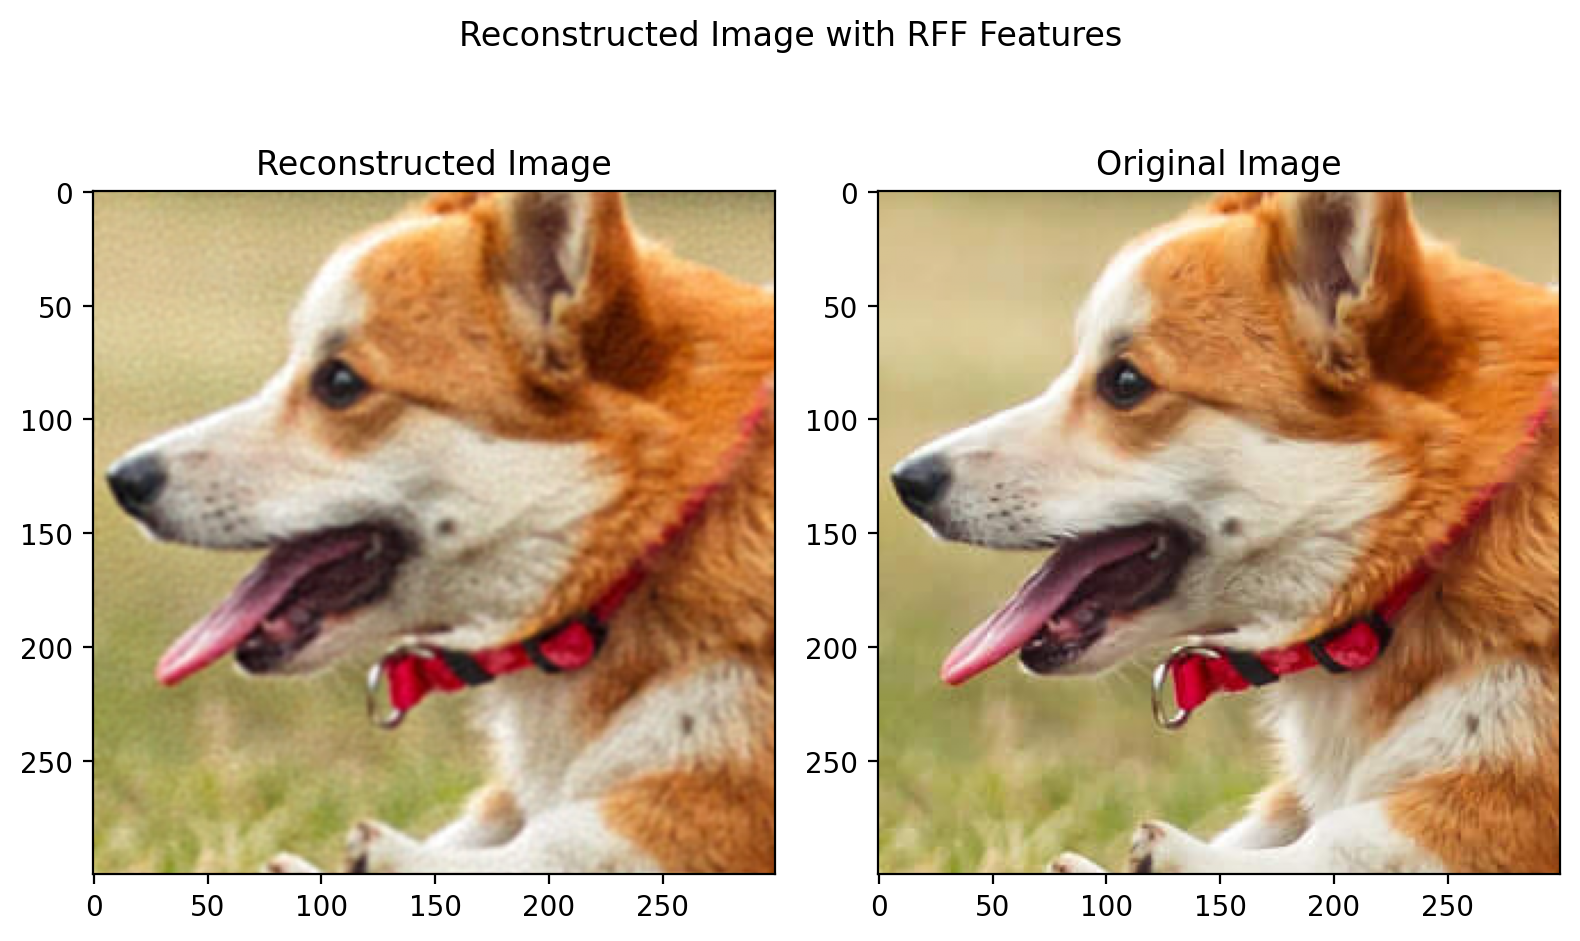

In [20]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features", scale = 1, allowSave = True, fileName = "./SIRENDog/Reconstruct1.png")

In [21]:
import gc
del X_rff
torch.cuda.empty_cache()
gc.collect()

6549

In [22]:
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()

    X = X.to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [23]:
dog_X, dog_Y = create_coordinate_map(crop, scale = 2)
print(dog_X.shape, dog_Y.shape)

torch.Size([360000, 2]) torch.Size([90000, 3])


In [24]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()
print(dog_X_scaled.shape)
print(dog_X_scaled[:10, :])

torch.Size([360000, 2])
tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9967],
        [-1.0000, -0.9933],
        [-1.0000, -0.9900],
        [-1.0000, -0.9866],
        [-1.0000, -0.9833],
        [-1.0000, -0.9800],
        [-1.0000, -0.9766],
        [-1.0000, -0.9733],
        [-1.0000, -0.9699]], device='cuda:0')


In [25]:
X_rff = create_rff_features(dog_X_scaled, 15500, 0.008)
print(X_rff.shape)

torch.Size([360000, 15500])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


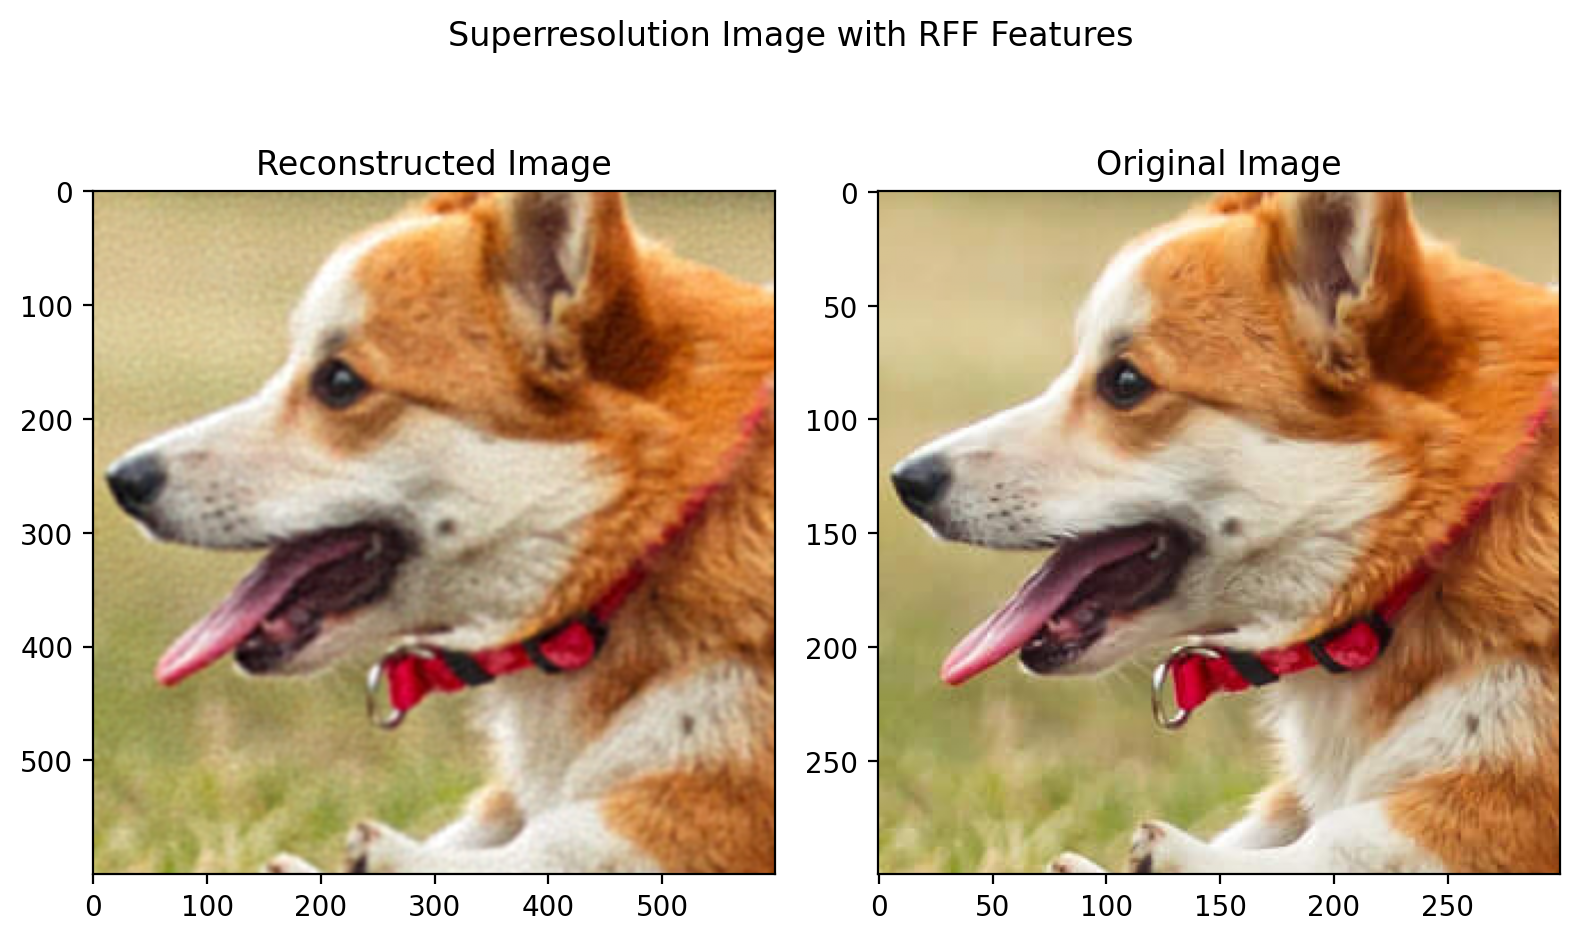

In [26]:
plot_reconstructed_and_original_image(crop, net, X_rff, title = "Superresolution Image with RFF Features", scale = 2, allowSave = True, fileName = "./SIRENDog/Superresolution1.png")